In [1]:
import pandas as pd
import os
import time
import numpy as np
import pandas as pd
#from sklearnex import patch_sklearn #use intel patch before importing sklearn
#patch_sklearn()
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn import linear_model, svm, tree, ensemble, neighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
import lightgbm as lgbm

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import  ensemble

In [2]:
#%cd ./network_sniff/
#%ls

# 0) Create reporting 

In [3]:
def model_cv_rapport(model , name  : str, x : np.array, y : np.array, cv=5, precision = 8):
    """
    Apply the model then cross validate and export its score 
    """
    #making sure data is standarized
    pipe = Pipeline([
        ('scale', preprocessing.StandardScaler()),
        ('clf', model)
    ])
    score = cross_validate(pipe, x, y, cv=cv,
                           scoring=["precision", "recall", "f1", "roc_auc", "accuracy"],
                           #verbose=10,
                           n_jobs=-1)
    print (name, "--------------------------------------")
    print("Precision: ", round(score["test_precision"].mean(), precision))
    print("Recall: ", round(score["test_recall"].mean(), precision))
    print("F1: ", round(score["test_f1"].mean(), precision))
    print("ROC: ", round(score["test_roc_auc"].mean(), precision))
    print("Accuracy: ", round(score["test_accuracy"].mean(), precision))

# 1) Import the dataset

As https://doi.org/10.1016/j.comcom.2021.02.016 and promizing : http://doi.acm.org/10.1145/3243734.3243858


In [4]:
df_mining = pd.read_csv(os.getcwd()+'/network_sniff/traffic_minage_1811_15.csv', index_col= 0)
df_not_mining = pd.read_csv(os.getcwd()+'/network_sniff/2911_traffic_calme.csv', index_col= 0)

In [5]:
df_mining.groupby('Destination').count()


,Time,Source,Protocol,Length,Info
Destination,,,,,
10.29.231.206,37,37,37,37,37
178.128.242.134,6,6,6,6,6
192.44.75.10,2,2,2,2,2
199.247.27.41,1,1,1,1,1
23.200.86.233,8,8,8,8,8
23.200.87.12,6,6,6,6,6
34.120.208.123,2,2,2,2,2
34.160.144.191,2,2,2,2,2
34.98.75.36,2,2,2,2,2


We define all traffic trom the mining dataset as comming from the miner and all the one from the other dataset as not mining
Moreover we add the direction of the package

In [6]:
df_mining['miner'] = True
df_mining['outbound'] = df_mining['Source'].apply(lambda x : x == '10.29.231.206') #change ip of miner
df_not_mining['miner'] = False
df_not_mining['outbound'] = df_not_mining['Source'].apply(lambda x : x == '10.29.229.98')

Compute time difference between two packages

In [7]:
df_mining['delta'] = df_mining.Time.diff()
df_not_mining['delta'] = df_not_mining.Time.diff()

Compute time and packet size rolling average and std

In [8]:
window = 4

In [9]:
# delta
# Rolling average
df_mining['ra_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['ra_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_delta'] = df_mining.delta.rolling(window=window).mean()
df_not_mining['rstd_delta'] = df_not_mining.delta.diff().rolling(window=window).mean()

# Lenght
# Rolling average
df_mining['ra_lenght'] = df_mining.Length.rolling(window=window).mean()
df_not_mining['ra_lenght'] = df_not_mining.Length.diff().rolling(window=window).mean()
# Standard Deviation
df_mining['rstd_lenght'] = df_mining.Length.rolling(window=window).std()
df_not_mining['rstd_lenght'] = df_not_mining.Length.diff().rolling(window=window).std()


In [10]:
df_ML = pd.concat([df_mining, df_not_mining], ignore_index=True)
df_ML.reset_index(inplace = True, drop = True)
df_ML.drop(['Time', 'Source', 'Destination', 'Protocol', 'Info'], axis = 1, inplace = True)


In [11]:
df_ML.describe()

,Length,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
count,41272.000000,4.127000e+04,4.126300e+04,4.126300e+04,41265.000000,41265.000000
mean,753.771613,3.151798e-02,1.453039e-03,1.453039e-03,0.168939,1332.260381
std,1059.517408,6.948798e-01,2.461157e-01,2.461157e-01,282.003832,1201.291351
min,42.000000,-6.600010e-08,-2.729894e+01,-2.729894e+01,-1134.000000,0.000000
25%,66.000000,1.103925e-05,-5.942175e-05,-5.942175e-05,-20.250000,175.200837
50%,105.000000,1.887860e-04,-4.725001e-08,-4.725001e-08,0.000000,1143.095213
75%,1466.000000,4.567025e-04,5.934062e-05,5.934062e-05,21.750000,2364.574098
max,6806.000000,1.092041e+02,2.730102e+01,2.730102e+01,1637.750000,5287.348422


In [12]:
df_ML.describe()
df_ML.dropna(inplace = True)
df_ML.columns

Index(['Length', 'miner', 'outbound', 'delta', 'ra_delta', 'rstd_delta',
       'ra_lenght', 'rstd_lenght'],
      dtype='object')

In [13]:
df_ML.groupby('miner').mean()

,Length,outbound,delta,ra_delta,rstd_delta,ra_lenght,rstd_lenght
miner,,,,,,,
False,755.204045,0.468117,0.030102,-4.894163e-08,-4.894163e-08,-0.005330,1334.872385
True,84.024691,0.543210,0.753654,7.402318e-01,7.402318e-01,86.472222,30.853181


array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>],
       [<AxesSubplot: title={'center': 'ra_delta'}>,
        <AxesSubplot: title={'center': 'rstd_delta'}>],
       [<AxesSubplot: title={'center': 'ra_lenght'}>,
        <AxesSubplot: title={'center': 'rstd_lenght'}>]], dtype=object)

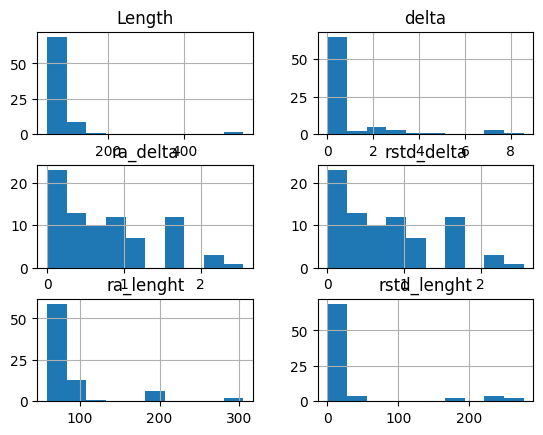

In [14]:
df_ML.loc[df_ML['miner'] == True].hist()

array([[<AxesSubplot: title={'center': 'Length'}>,
        <AxesSubplot: title={'center': 'delta'}>],
       [<AxesSubplot: title={'center': 'ra_delta'}>,
        <AxesSubplot: title={'center': 'rstd_delta'}>],
       [<AxesSubplot: title={'center': 'ra_lenght'}>,
        <AxesSubplot: title={'center': 'rstd_lenght'}>]], dtype=object)

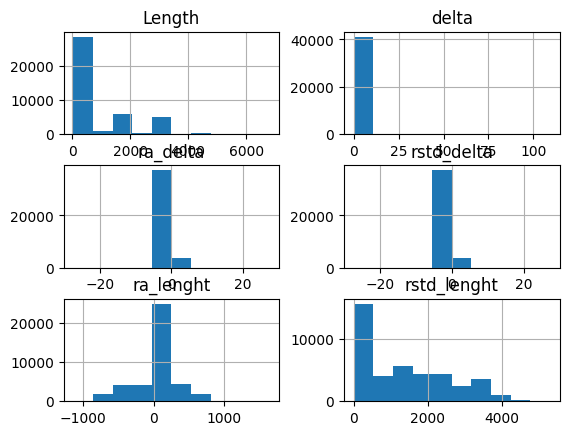

In [15]:
df_ML.loc[df_ML['miner'] == False].hist()

In [16]:
y = df_ML['miner']
X = df_ML.drop('miner', axis = 1)

In [17]:
y.describe

<bound method NDFrame.describe of 4         True
5         True
6         True
7         True
8         True
         ...  
41267    False
41268    False
41269    False
41270    False
41271    False
Name: miner, Length: 41263, dtype: bool>

In [18]:
y.value_counts()

False    41182
True        81
Name: miner, dtype: int64

# ML Algorithm
## AUTOSKLEARN

In [19]:
#import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from pprint import pprint
import joblib


In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

In [21]:
# load trained model
automl = joblib.load("autosklearn")

'''
# Set a autosklearn model, use the 5 folds cross validation
automl = autosklearn.classification.AutoSklearnClassifier(resampling_strategy="cv",resampling_strategy_arguments={'folds': 5})
automl.fit(X_train, y_train)
'''

'\n# Set a autosklearn model, use the 5 folds cross validation\nautoml = autosklearn.classification.AutoSklearnClassifier(resampling_strategy="cv",resampling_strategy_arguments={\'folds\': 5})\nautoml.fit(X_train, y_train)\n'

In [22]:
y_pred = automl.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred, average='weighted'))
print('F1-score:', f1_score(y_test, y_pred, average='weighted'))
print('Precision score:', precision_score(y_test, y_pred, average='weighted'))

Accuracy score: 0.9977704536642109
Recall: 0.9977704536642109
F1-score: 0.9966569246024284
Precision score: 0.9955458782052853


/home/augustin/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
'''
# Save trained model
joblib.dump(automl, 'autosklearn')
'''

"\n# Save trained model\njoblib.dump(automl, 'autosklearn')\n"

In [25]:
automl.cv_results_

{'mean_test_score': array([0., 0., 0., ..., 0., 0., 0.]),
 'rank_test_scores': array([1, 1, 1, ..., 1, 1, 1]),
 'mean_fit_time': array([0.62945247, 0.6328783 , 0.62888718, ..., 0.49508691, 0.43440247,
        0.6839962 ]),
 'params': [{'balancing:strategy': 'none',
   'classifier:__choice__': 'random_forest',
   'data_preprocessor:__choice__': 'feature_type',
   'feature_preprocessor:__choice__': 'no_preprocessing',
   'classifier:random_forest:bootstrap': 'True',
   'classifier:random_forest:criterion': 'gini',
   'classifier:random_forest:max_depth': 'None',
   'classifier:random_forest:max_features': 0.5,
   'classifier:random_forest:max_leaf_nodes': 'None',
   'classifier:random_forest:min_impurity_decrease': 0.0,
   'classifier:random_forest:min_samples_leaf': 1,
   'classifier:random_forest:min_samples_split': 2,
   'classifier:random_forest:min_weight_fraction_leaf': 0.0,
   'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encodi

In [26]:
automl.sprint_statistics()

'auto-sklearn results:\n  Dataset name: 995db581-7c7a-11ed-8746-02758695c782\n  Metric: accuracy\n  Number of target algorithm runs: 1677\n  Number of successful target algorithm runs: 0\n  Number of crashed target algorithm runs: 1677\n  Number of target algorithms that exceeded the time limit: 0\n  Number of target algorithms that exceeded the memory limit: 0\n'